## 1.1 导入库

In [8]:
import os
import shutil
import numpy as np
from paddle.io import Dataset,DataLoader
from paddle.vision import transforms as T
from paddle.nn import functional as F
import cv2
import paddle
import matplotlib.pyplot as plt
import paddle.nn as nn
from tqdm import tqdm

##检查飞浆框架是否下载完成

In [9]:
paddle.utils.run_check()

Running verify PaddlePaddle program ... 
PaddlePaddle works well on 1 CPU.
PaddlePaddle is installed successfully! Let's start deep learning with PaddlePaddle now.


##检查gpu能否运行

In [10]:
import torch
device = torch.device("cuda:0"  if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1.2 定义超参

In [11]:
#验证集的数量
eval_num=1000
#所有图像的大小
image_size=(224,224)
#训练图片路径
train_images_path="data/train_image"
#标签图像路径
label_images_path="data/train_50k_mask"
#测试图片路径
test_images_path="data/val_image"
#批量大小
batch_size=4

# 二、数据集
## 数据集划分
1. 训练数据集包括50,000幅像素级有标注的图像，共包含500个类，每个类100幅图像。[点击下载](https://aistudio.baidu.com/aistudio/datasetdetail/95703)；
2. A榜测试数据集包括11,878幅无标注的图像。[点击下载](https://aistudio.baidu.com/aistudio/datasetdetail/95703)
3. B榜测试数据集包括10,989幅无标注的图像。[点击下载](https://aistudio.baidu.com/aistudio/datasetdetail/100087)


## 文件目录
```
|---|train_image #原始图像
|---|---|n014443537 #文件夹，类别
|---|---|---|n01443537_2.png #图像
|---|---|---|……
|---|---|n01491361
|---|---|---|n01443537_176.png #图像
|---|---|---|……
……

|---|train_50k_mask #标注图像
|---|---|n014443537 #文件夹，类别
|---|---|---|n01443537_2.png #图像
|---|---|---|……
|---|---|n01491361
|---|---|---|n01443537_176.png #图像
|---|---|---|……
……

|---|val_image #测试提交
|---|---|ILSVRC2012_val_00000001.JPEG
|---|---|ILSVRC2012_val_00000004.JPEG
|---|---|……


```
## 图像可视化
原始图像VS标注图像

<center>
    <img src="https://ai-studio-static-online.cdn.bcebos.com/a74cf67e3ab741b99aed5ed7734c5d8f8d40219eab7b4cafa59e96e17f701714" width=40% align=left>
    <img src="https://ai-studio-static-online.cdn.bcebos.com/af685ee04f5f4acbaaba5141ce2c558440729d14762c412a94f02bb70a2e1c1d" width=40% align=right>
</center>
    
    
<center>
    <img src="https://ai-studio-static-online.cdn.bcebos.com/40dd8e974a1d4981a9fc1444fa229a3d95efbf6cd16c4081a0009fc567c0605e" width=40% align=left>
    <img src="https://ai-studio-static-online.cdn.bcebos.com/1f80bca410944e2c803959c7e75f32208da50e2a796a4331a0e4fd1db10b7f1f" width=40% align=right>
</center>


## 2.1 解压数据集
默认解压到/data目录下，该目录会在每次进入环境时重置，但可以节省项目启动时间。

In [12]:
!unzip -oq /home/aistudio/data/data95249/train_image.zip -d data/
!unzip -oq /home/aistudio/data/data95249/train_50k_mask.zip -d data/
!unzip -oq /home/aistudio/data/data95249/第一阶段test.zip -d data/

'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
'unzip' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


## 2.2 读取图像路径
- input：

```
train_images_path="data/train_image"

label_images_path="data/train_50k_mask"
```
- output：

```
shape = (49000, 2)、(1000, 2)、(11878, 1)

train_data[0] = ['data/train_image/n02910353/n02910353_3750.png', 'data/train_50k_mask/n02910353/n02910353_3750.png']

eval_data[0] = ['data/train_image/n03785016/n03785016_285.png','data/train_50k_mask/n03785016/n03785016_285.png']
 
test_data = ['data/val_image/ILSVRC2012_val_00011639.JPEG']
```

In [13]:
def get_path(image_path):
    files=[]
    for dir_name in os.listdir(image_path):
        for image_name in os.listdir(os.path.join(image_path,dir_name)):
            if image_name.endswith('.png') and not image_name.startswith('.'):
                files.append(os.path.join(image_path,dir_name,image_name))
    return sorted(files)

def get_test_data(test_images_path):
    test_data=[]
    for name in os.listdir(test_images_path):
        img_path=os.path.join(test_images_path,name)
        test_data.append(img_path)
    test_data=np.expand_dims(np.array(test_data),axis=1)
    return test_data

#扩展一维，以便将images与labels合并
images=np.expand_dims(np.array(get_path(train_images_path)),axis=1)
labels=np.expand_dims(np.array(get_path(label_images_path)),axis=1)
data=np.array(np.concatenate((images,labels),axis=1))
#打乱数据，同时也不会影响images与labels的对应关系
np.random.shuffle(data)
#分割数据集
train_data=data[:-eval_num,:]
eval_data=data[-eval_num:,:]
test_data=get_test_data(test_images_path)
print(train_data.shape, train_data[0])
print(eval_data.shape, eval_data[0])
print(test_data.shape, test_data[0])

(49000, 2) ['data/train_image\\n02109047\\n02109047_44819.png'
 'data/train_50k_mask\\n02109047\\n02109047_44819.png']
(1000, 2) ['data/train_image\\n03637318\\n03637318_8607.png'
 'data/train_50k_mask\\n03637318\\n03637318_8607.png']
(11878, 1) ['data/val_image\\ILSVRC2012_val_00000001.JPEG']


## 2.3 数据增强
封装数据预处理函数，其中训练集与验证集、测试集的函数不同，训练集可以加入图像色彩的调整，但如果要加入水平翻转，缩放等方法，注意要同时对label也做同样处理验证集和测试集可以将图像色彩的调整去掉，因为加入数据预处理的原因是扩大特征空间，使得模型有更好的拟合能力，但验证集就没必要扩大数据的特征空间了。

In [14]:
train_transform=T.Compose([
            T.Resize(image_size),  #裁剪
            T.ColorJitter(0.1,0.1,0.1,0.1), #亮度，对比度，饱和度和色调
            T.Transpose(), #CHW
            T.Normalize(mean=0.,std=255.) #归一化
        ])
eval_transform=T.Compose([
            T.Resize(image_size),
            T.Transpose(),
            T.Normalize(mean=0.,std=255.)
        ])

## 2.4 定义数据读取器
- 继承Paddle.io.Dataset类
- 调用Paddle.io.DataLoader类

In [15]:
class ImageDataset(Dataset):
    def __init__(self,path,transform):
        super(ImageDataset, self).__init__()
        self.path=path
        self.transform=transform

    def _load_image(self,path):
        '''
        该方法作用为通过路径获取图像
        '''
        img=cv2.imread(path)
        img=cv2.resize(img,image_size)
        return img

    def __getitem__(self,index):
        '''
        这里之所以不对label使用transform，因为观察数据集发现label的图像矩阵主要为0或1
        但偶尔也有0-255的值，所以要对label分情况处理
        而对data都进行transform是因为data都是彩色图片，图像矩阵皆为0-255，所以可以统一处理
        '''
        path=self.path[index]
        if len(path)==2:
            data_path,label_path=path
            data,label=self._load_image(data_path),self._load_image(label_path)
            data,label=self.transform(data),label
            label = label.transpose((2, 0, 1))
            label = label[0, :, :]
            label = np.expand_dims(label, axis=0)
            if True in (label>1):
                label=label/255.
            label = label.astype("int64")
            return data,label
            
        
        if len(path)==1:
            data=self._load_image(path[0])
            data=self.transform(data)
            return data

    def __len__(self):
        return len(self.path)

#获取数据读取器
train_dataset=ImageDataset(train_data,train_transform)
eval_dataset=ImageDataset(eval_data,eval_transform)
test_dataset=ImageDataset(test_data,eval_transform)
train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,drop_last=True)
eval_dataloader=DataLoader(eval_dataset,batch_size=batch_size,shuffle=True,drop_last=True)

## 2.5 观察读取的图像

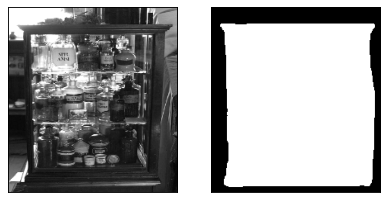

In [16]:
def show_images(imgs):
    #imgs是一个列表，列表里是多个tensor对象
    #定义总的方框的大小
    plt.figure(figsize=(3*len(imgs),3), dpi=80)
    for i in range(len(imgs)):
        #定义小方框
        plt.subplot(1, len(imgs), i + 1)
        #matplotlib库只能识别numpy类型的数据，tensor无法识别
        imgs[i]=imgs[i].numpy()
        #展示取出的数据
        plt.imshow(imgs[i][0],cmap="gray",aspect="auto")
        #设置坐标轴
        plt.xticks([])
        plt.yticks([])

data,label=next(train_dataloader())
show_images([data[0],label[0]])

# 三、网络模型搭建

## 3.1 UNet
U-Net网络结构因为形似字母“U”而得名，最早是在医学影像的细胞分割任务中提出，结构简单适合处理小数量级的数据集。比较于FCN网络的像素相加，U-Net是对通道进行concat操作，保留上下文信息的同时，加强了它们之间的语义联系。整体是一个Encode-Decode的结构，如下图所示。
<center>
<img src="https://img-blog.csdnimg.cn/a8304e5957a34a1a92a804bb9bfd231e.png" width=100%>
</center>

* **知识点1**:下采样Encode包括conv和max pool，上采样Decode包括up-conv和conv。
* **知识点2**:U-Net特点在于灰色箭头，利用通道融合使上下文信息紧密联系起来。

In [17]:
"""
paddlepaddle-gpu==2.2.1
time:2021.07.16 9:00
author:CP
backbone：U-net
"""
import paddle
from paddle import nn
class Encoder(nn.Layer):#下采样：两层卷积，两层归一化，最后池化。
    def __init__(self, num_channels, num_filters):
        super(Encoder,self).__init__()#继承父类的初始化
        self.conv1 = nn.Conv2D(in_channels=num_channels,
                              out_channels=num_filters,
                              kernel_size=3,#3x3卷积核，步长为1，填充为1，不改变图片尺寸[H W]
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")#归一化，并使用了激活函数
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
        self.pool  = nn.MaxPool2D(kernel_size=2,stride=2,padding="SAME")#池化层，图片尺寸减半[H/2 W/2]
        
    def forward(self,inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x_conv = x           #两个输出，灰色 ->
        x_pool = self.pool(x)#两个输出，红色 | 
        return x_conv, x_pool
    
    
class Decoder(nn.Layer):#上采样：一层反卷积，两层卷积层，两层归一化
    def __init__(self, num_channels, num_filters):
        super(Decoder,self).__init__()
        self.up = nn.Conv2DTranspose(in_channels=num_channels,
                                    out_channels=num_filters,
                                    kernel_size=2,
                                    stride=2,
                                    padding=0)#图片尺寸变大一倍[2*H 2*W]

        self.conv1 = nn.Conv2D(in_channels=num_filters*2,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn1   = nn.BatchNorm(num_filters,act="relu")
        
        self.conv2 = nn.Conv2D(in_channels=num_filters,
                              out_channels=num_filters,
                              kernel_size=3,
                              stride=1,
                              padding=1)
        self.bn2   = nn.BatchNorm(num_filters,act="relu")
        
    def forward(self,input_conv,input_pool):
        x = self.up(input_pool)
        h_diff = (input_conv.shape[2]-x.shape[2])
        w_diff = (input_conv.shape[3]-x.shape[3])
        pad = nn.Pad2D(padding=[h_diff//2, h_diff-h_diff//2, w_diff//2, w_diff-w_diff//2])
        x = pad(x)                                #以下采样保存的feature map为基准，填充上采样的feature map尺寸
        x = paddle.concat(x=[input_conv,x],axis=1)#考虑上下文信息，in_channels扩大两倍
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x
    
class UNet(nn.Layer):
    def __init__(self,num_classes=59):
        super(UNet,self).__init__()
        self.down1 = Encoder(num_channels=  3, num_filters=64) #下采样
        self.down2 = Encoder(num_channels= 64, num_filters=128)
        self.down3 = Encoder(num_channels=128, num_filters=256)
        self.down4 = Encoder(num_channels=256, num_filters=512)
        
        self.mid_conv1 = nn.Conv2D(512,1024,1)                 #中间层
        self.mid_bn1   = nn.BatchNorm(1024,act="relu")
        self.mid_conv2 = nn.Conv2D(1024,1024,1)
        self.mid_bn2   = nn.BatchNorm(1024,act="relu")

        self.up4 = Decoder(1024,512)                           #上采样
        self.up3 = Decoder(512,256)
        self.up2 = Decoder(256,128)
        self.up1 = Decoder(128,64)
        
        self.last_conv = nn.Conv2D(64,num_classes,1)           #1x1卷积，softmax做分类
        
    def forward(self,inputs):
        x1, x = self.down1(inputs)
        x2, x = self.down2(x)
        x3, x = self.down3(x)
        x4, x = self.down4(x)
        
        x = self.mid_conv1(x)
        x = self.mid_bn1(x)
        x = self.mid_conv2(x)
        x = self.mid_bn2(x)
        
        x = self.up4(x4, x)
        x = self.up3(x3, x)
        x = self.up2(x2, x)
        x = self.up1(x1, x)
        
        x = self.last_conv(x)
        
        return x
paddle.summary(UNet(), (1, 3, 600, 600))

---------------------------------------------------------------------------------------------------------------------
  Layer (type)                  Input Shape                              Output Shape                   Param #    
    Conv2D-1                 [[1, 3, 600, 600]]                       [1, 64, 600, 600]                  1,792     
   BatchNorm-1              [[1, 64, 600, 600]]                       [1, 64, 600, 600]                   256      
    Conv2D-2                [[1, 64, 600, 600]]                       [1, 64, 600, 600]                 36,928     
   BatchNorm-2              [[1, 64, 600, 600]]                       [1, 64, 600, 600]                   256      
   MaxPool2D-1              [[1, 64, 600, 600]]                       [1, 64, 300, 300]                    0       
    Encoder-1                [[1, 3, 600, 600]]             [[1, 64, 600, 600], [1, 64, 300, 300]]         0       
    Conv2D-3                [[1, 64, 300, 300]]                       

{'total_params': 18476155, 'trainable_params': 18464379}

## 3.2 PSPNet
Pyramid Scene Parsing Network（PSPNet）网络结构形似金字塔而被命名，能够聚合不同尺度下的上下文信息，在场景解析上有很好的效果。PSPNet的精髓在于pyramid parsing module的构建，能够增大深层区域的感受野。
<center>
    <img src="https://img-blog.csdnimg.cn/a9f97cbcd2a444659b28bbfa8c6d01c6.png" width=100%>
</center>

* **知识点1**:多尺度特征融合可以提高模型性能，深层网络中包含更多的语义信息和较小的位置信息。
* **知识点2**:input image需要通过CNN网路提取特征，这里使用的是飞桨预训练的resnet50网络。
<center>
    <img src="https://img-blog.csdnimg.cn/cfc26d218064444dbd2ac73fd7d05ea2.png">
</center>

* **知识点3**:PSPmodule将CNN的输出划成四个通道，然后进行上采样，全局特征和局部特征进行融合得到2C通道。
<center>
    <img src="https://img-blog.csdnimg.cn/539fc019ec5b4639b3b49b38a613ecd4.png" width = 80%>
</center>

In [18]:
"""
paddlepaddle-gpu==2.2.1
time:2021.07.16 9:00
author:CP
backbone：PSPnet
"""
import paddle
import paddle.nn as nn

class PSPModule(nn.Layer):
    """
    num_channels：输入通道数为C
    num_filters ：输出通道数为C/4
    bin_size_list=[1,2,3,6]
    get1:
        nn.LayerList创建一个空列表的层
        .append拼接“层”的列表
    get2:
        paddle.nn.AdaptiveMaxPool2D输出固定尺寸的image_size[H,W]
        paddle.nn.functional.interpolate卷积操作后，还原图片尺寸大小
        paddle.concat [H,W]同尺寸的图片，合并通道[C]
    """    
    def __init__(self, num_channels, bin_size_list):
        super(PSPModule,self).__init__()
        num_filters = num_channels // len(bin_size_list) #C/4
        self.features = nn.LayerList()         #一个层的空列表
        for i in range(len(bin_size_list)):
            self.features.append(
                paddle.nn.Sequential(
                    paddle.nn.AdaptiveMaxPool2D(output_size=bin_size_list[i]),
                    paddle.nn.Conv2D(in_channels=num_channels, out_channels=num_filters, kernel_size=1),
                    paddle.nn.BatchNorm2D(num_features=num_filters)
                )
            )
    def forward(self, inputs):
        out = [inputs] #list
        for idx, layerlist in enumerate(self.features):
            x = layerlist(inputs)
            x = paddle.nn.functional.interpolate(x=x, size=inputs.shape[2::], mode='bilinear', align_corners=True)
            out.append(x)
        out = paddle.concat(x=out, axis=1) #NCHW
        return out

from paddle.vision.models import resnet50
class PSPnet(nn.Layer):
    def __init__(self, num_classes=59, backbone='resnet50'):
        super(PSPnet, self).__init__()
        """
        https://github.com/PaddlePaddle/Paddle/blob/release/2.1/python/paddle/vision/models/resnet.py
        重复利用resnet50网络模型：
            1.初始化函数关键词——backbone
            2.神经网络模型实例化
            3.源代码查找层的变量名
        """
        # resnet50 3->2048
        res = resnet50()
        self.layer0 = nn.Sequential(res.conv1, res.bn1, res.relu, res.maxpool)
        self.layer1 = res.layer1
        self.layer2 = res.layer2
        self.layer3 = res.layer3
        self.layer4 = res.layer4#输出通道为2048
        
        #pspmodule 2048->4096
        num_channels = 2048
        self.pspmodule = PSPModule(num_channels, [1,2,3,6])
        num_channels *= 2
        
        #cls 4096->num_classes
        self.classifier = nn.Sequential(
                             nn.Conv2D(num_channels,512,3,1,1),
                             nn.BatchNorm(512,act='relu'),
                             nn.Dropout(),
                             nn.Conv2D(512,num_classes,1))
        #aux:1024->256->num_classes
        #单独分离出一层来计算函数损失
        
    def forward(self,inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pspmodule(x)
        x = self.classifier(x)
        x = paddle.nn.functional.interpolate(x=x, size=inputs.shape[2::], mode='bilinear', align_corners=True)
        return x

paddle.summary(PSPnet(), (1, 3, 600, 600))

-------------------------------------------------------------------------------
   Layer (type)         Input Shape          Output Shape         Param #    
     Conv2D-20       [[1, 3, 600, 600]]   [1, 64, 300, 300]        9,408     
   BatchNorm2D-1    [[1, 64, 300, 300]]   [1, 64, 300, 300]         256      
      ReLU-1        [[1, 64, 300, 300]]   [1, 64, 300, 300]          0       
    MaxPool2D-5     [[1, 64, 300, 300]]   [1, 64, 150, 150]          0       
     Conv2D-22      [[1, 64, 150, 150]]   [1, 64, 150, 150]        4,096     
   BatchNorm2D-3    [[1, 64, 150, 150]]   [1, 64, 150, 150]         256      
      ReLU-2        [[1, 256, 150, 150]]  [1, 256, 150, 150]         0       
     Conv2D-23      [[1, 64, 150, 150]]   [1, 64, 150, 150]       36,864     
   BatchNorm2D-4    [[1, 64, 150, 150]]   [1, 64, 150, 150]         256      
     Conv2D-24      [[1, 64, 150, 150]]   [1, 256, 150, 150]      16,384     
   BatchNorm2D-5    [[1, 256, 150, 150]]  [1, 256, 150, 150]  

{'total_params': 46672891, 'trainable_params': 46614651}

## 3.3 Deeplabv3
空洞卷积（Dilatee/Atrous Convolution）是一种特殊的卷积算子，针对卷积神经网络在下采样时图像分辨率降低、部分信息丢失而提出的卷积思路，通过在卷积核中添加空洞以获得更大的感受野。

![](https://ai-studio-static-online.cdn.bcebos.com/cedf91586d0045c5a031ba5cfc2204996933d4d72c934dd7adc2a5f4366fec58)

* 3x3卷积核，dilation rate 分别为1， 2， 4，空洞部分填充零。
* 输入大小为[H，W]，卷积核大小为{FH，FW]，填充为P，步幅为S，计算输出大小
$$
\begin{aligned}
&O H=\frac{H+2 P-F H}{S}+1 \\
&O W=\frac{W+2 P-F W}{S}+1
\end{aligned}
$$
* 3x3卷积核可以等效为5x5，假设卷积核大小k=3，空洞数d=2，则等效卷积核k‘，感受野RF，第一层感受野为3，Si为之前所有层步长的乘积。RFa=3，RFb=5，RFc=8。
$$
\begin{aligned}
&k^{\prime}=k+(k-1) \times(d-1)\\
&R F_{i+1}=R F_{i}+\left(k^{\prime}-1\right) \times S_{i}\\
&S_{i}=\prod_{i=1}^{i} \text { Stride }_{i}
\end{aligned}
$$
$$
\begin{aligned}
&k^{\prime}=3+(3-1) \times(2-1)=5\\
&R F_{i+1}=3+(5-1) \times S_{i}\\
&S_{i}=\prod_{i=1}^{i} \text { Stride }_{i}=1
\end{aligned}
$$

![](https://ai-studio-static-online.cdn.bcebos.com/c5a720628d9442a68674f5fe7a7789c129ba12712c254c13a62e54c1bbf1b8b2)



In [19]:
"""
paddlepaddle-gpu==2.2.1
time:2021.07.20 9:00
author:CP
Deeplabv3
"""
import paddle
import paddle.nn as nn

class ASPPPooling(nn.Layer):
    def __init__(self,num_channels,num_filters):
        super(ASPPPooling,self).__init__()
        self.adaptive_pool = nn.AdaptiveMaxPool2D(output_size=3)
        self.features = nn.Sequential(
                                        nn.Conv2D(num_channels, num_filters,1),
                                        nn.BatchNorm(num_filters, act="relu")
                                          )
        
    def forward(self, inputs):
        n1, c1, h1, w1 = inputs.shape
        x = self.adaptive_pool(inputs)
        x = self.features(x)
        x = nn.functional.interpolate(x, (h1, w1), align_corners=False)
        return x

class ASPPConv(nn.Layer):
    def __init__(self,num_channels,num_filters,dilations):
        super(ASPPConv,self).__init__()
        self.asppconv = nn.Sequential(
                            nn.Conv2D(num_channels,num_filters,3,padding=dilations,dilation=dilations),
                            nn.BatchNorm(num_filters, act="relu")
                            )
        
    def forward(self,inputs):
        x = self.asppconv(inputs)
        return x

#ASPP模块最大的特点是使用了空洞卷积来增大感受野
class ASPPModule(nn.Layer):
    def __init__(self, num_channels, num_filters, rates):
        super(ASPPModule, self).__init__()
        self.features = nn.LayerList()
        #层一
        self.features.append(nn.Sequential(
                                        nn.Conv2D(num_channels, num_filters,1),
                                        nn.BatchNorm(num_filters, act="relu")
                                          )
                            )
        #层二
        for r in rates:
            self.features.append(ASPPConv(num_channels, num_filters, r))
        #层三
        self.features.append(ASPPPooling(num_channels, num_filters))
        #层四
        self.project  = nn.Sequential(
                                    nn.Conv2D(num_filters*(2+len(rates)), num_filters, 1),#TODO
                                    nn.BatchNorm(num_filters, act="relu")
                                     )
    def forward(self, inputs):
        out = []
        for op in self.features:
            out.append(op(inputs))
        x = paddle.concat(x=out,axis=1)
        x = self.project(x)
        return x

class DeeplabHead(nn.Layer):
    def __init__(self, num_channels, num_classes):
        super(DeeplabHead, self).__init__()
        self.head = nn.Sequential(
                            ASPPModule(num_channels, 256, [12, 24, 36]),
                            nn.Conv2D(256, 256, 3, padding=1),
                            nn.BatchNorm(256, act="relu"),
                            nn.Conv2D(256, num_classes, 1)        
                            )
    def forward(self, inputs):
        x = self.head(inputs)
        return x

from paddle.vision.models import resnet50
from paddle.vision.models.resnet import BottleneckBlock
class Deeplabv3(nn.Layer):
    def __init__(self, num_classes=59, backbone='resnet50'):
        super(Deeplabv3, self).__init__()
        # resnet50 3->2048
        # resnet50 四层layers = [3 4 6 3]
        # 调用resnet.py模块，空洞卷积[2 4 8 16]
        res = resnet50()
        res.inplanes = 64        #初始化输入层
        self.layer0 = nn.Sequential(res.conv1, res.bn1, res.relu, res.maxpool)
        self.layer1 = res._make_layer(BottleneckBlock, 64,3)
        self.layer2 = res._make_layer(BottleneckBlock,128,4)
        self.layer3 = res._make_layer(BottleneckBlock,256,6)
        self.layer4 = res._make_layer(BottleneckBlock,512,3,stride=2,dilate= 2) #dilation=2        
        self.layer5 = res._make_layer(BottleneckBlock,512,3,stride=2,dilate= 4) #dilation=4
        self.layer6 = res._make_layer(BottleneckBlock,512,3,stride=2,dilate= 8) #dilation=8
        self.layer7 = res._make_layer(BottleneckBlock,512,3,stride=2,dilate=16) #dilation=16
        feature_dim = 2048      #输出层通道2048
        self.deeplabhead = DeeplabHead(feature_dim, num_classes)
        
    def forward(self, inputs):
        x = self.layer0(inputs)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        
        x = self.deeplabhead(x)#ASPP模块进行分类
        # 恢复原图尺寸
        x = paddle.nn.functional.interpolate(x=x, size=inputs.shape[2::], mode='bilinear', align_corners=True)
        return x
        
paddle.summary(Deeplabv3(), (1, 3, 600, 600))

--------------------------------------------------------------------------------
   Layer (type)          Input Shape          Output Shape         Param #    
     Conv2D-79       [[1, 3, 600, 600]]    [1, 64, 300, 300]        9,408     
  BatchNorm2D-58     [[1, 64, 300, 300]]   [1, 64, 300, 300]         256      
      ReLU-18        [[1, 64, 300, 300]]   [1, 64, 300, 300]          0       
    MaxPool2D-6      [[1, 64, 300, 300]]   [1, 64, 150, 150]          0       
    Conv2D-133       [[1, 64, 150, 150]]   [1, 64, 150, 150]        4,096     
  BatchNorm2D-112    [[1, 64, 150, 150]]   [1, 64, 150, 150]         256      
      ReLU-35       [[1, 256, 150, 150]]   [1, 256, 150, 150]         0       
    Conv2D-134       [[1, 64, 150, 150]]   [1, 64, 150, 150]       36,864     
  BatchNorm2D-113    [[1, 64, 150, 150]]   [1, 64, 150, 150]         256      
    Conv2D-135       [[1, 64, 150, 150]]   [1, 256, 150, 150]      16,384     
  BatchNorm2D-114   [[1, 256, 150, 150]]   [1, 256

F:\anaconda3\envs\qq\lib\site-packages\paddle\hapi\model_summary.py:525: RuntimeWarning: overflow encountered in scalar add
  total_output += np.sum(


{'total_params': 79925755, 'trainable_params': 79813755}

# 四、高层API训练

## 4.1 模型训练

In [20]:
#模型参数保存路径
work_path = "net_params/"
if os.path.exists(work_path):
    shutil.rmtree(work_path)
os.mkdir(work_path)

#实例化，网络三选一，默认U-Net
model = paddle.Model(UNet(2))       #U-Net
#model = paddle.Model(PSPnet(2))    #PSPNet
#model = paddle.Model(Deeplabv3(2)) #Deeplabv3

"""
beta1 = paddle.to_tensor([0.9], dtype="float32")
beta2 = paddle.to_tensor([0.99], dtype="float32")
opt=paddle.optimizer.Adam(learning_rate=1e-3
                            , beta1=0.9
                            , beta2=0.999
                            , epsilon=1e-08
                            , parameters=model.parameters()
                            , weight_decay=1e-2
                            , grad_clip=None
                            , name=None
                            )
"""
#定义优化器和损失函数
opt=paddle.optimizer.Momentum(learning_rate=1e-3,parameters=model.parameters(),weight_decay=1e-2)
model.prepare(opt, paddle.nn.CrossEntropyLoss(axis=1))
#启动模型训练
model.fit(train_dataloader, eval_dataloader, epochs=10,verbose=2,save_dir="./net_params",log_freq=200)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10


KeyboardInterrupt: 

## 4.2 模型预测

![](https://ai-studio-static-online.cdn.bcebos.com/91531674a8024bdca1a2f41552c518869096ed29d04a416d8d2ad2d2ef6f1713)

![](https://ai-studio-static-online.cdn.bcebos.com/5a2bc2c9d1334631b3de5f693fa8a14322e60d36a80e49e8b81c49402186d311)




In [ ]:
#预测图像保存路径
work_path = "/home/aistudio/data/val_label"
if os.path.exists(work_path):
    shutil.rmtree(work_path)
os.mkdir(work_path)

#读取模型参数文件路径
save_dir=work_path
checkpoint_path="./net_params/final"

#实例化，网络三选一，默认U-Net
model = paddle.Model(UNet(2))       #U-Net
#model = paddle.Model(PSPnet(2))    #PSPNet
#model = paddle.Model(Deeplabv3(2)) #Deeplabv3

model.load(checkpoint_path)
for i,img in tqdm(enumerate(test_dataset)):
    img=paddle.to_tensor(img).unsqueeze(0)
    predict=np.array(model.predict_batch(img)).squeeze(0).squeeze(0)
    predict=predict.argmax(axis=0)
    image_path=test_dataset.path[i]
    path_lst=image_path[0].split("/")
    save_path=os.path.join(save_dir,path_lst[-1][:-5])+".jpg"
    cv2.imwrite(save_path,predict*255)

# 五、总结提升

## 5.1 模型调优
提升图像预测精度最有效的方法是更换模型结构，优秀的网络模型决定了精度的上限，随着网络复杂程度的提高，模型训练时长以及模型参数大小都会有大的飞跃，在确定选用哪种网络模型后，模型参数调整可以小幅度提升模型精度的效果，可以总结为**模型结构粗调，模型参数微调**。

- 图像分割领域目前使用DeepLab系列的模型居多，本项目亦可验证结论：DeepLabv3>PSPNet>UNet，其中DeepLabv3训练时间过长，可以跳转到[基于PaddleSeg的图像分割模型训练项目](https://aistudio.baidu.com/aistudio/projectdetail/2249209)

- 模型参数选择集中在优化器、学习率、损失函数等方面，多次实验发现Momentum优化器、lr=0.001、CrossEntropyLoss损失函数对本项目比较友好，当然还可以从数据增强、激活函数、模型融合等方面考虑。


## 5.2 结果记录
##############################

* 2021年07月03日
* 网络骨架：U-net基线
* 项目编号：000
* 编译环境：飞桨paddle
* 定义参数：batch_size=8，epoch=5
* 运行时间：起始（10:00），结束（14:00）
* IoU成绩：0.37496

##############################

* 2021年07月04日
* 网络骨架：U-net
* 项目编号：005
* 编译环境：飞桨paddle
* 定义参数：batch_size=4，epoch=10
* 运行时间：起始（20:20），结束（22:00）
* 学习率：1e-3
* IoU成绩：0.5309

##############################

* 2021年07月05日
* 项目编号：007
* 网络模型：PSPnet
* 编译环境：飞桨paddle
* 定义参数：batch_size=8，epoch=3
* 运行时间：起始（18:30），结束（22:00）
* 学习率：1e-3
* 网络模型：PSPnet
* IoU成绩[0]:0.43250	loss
* IoU成绩[1]:0.43250	loss->0.5190	acc->0.0854
* IoU成绩[2]:0.52799	loss->0.3316	acc->0.1412

##############################

* 2021年07月08日
* 网络模型：PSPnet
* 项目编号：008
* 编译环境：飞桨paddle
* 定义参数：batch_size=16，epoch=30
* 运行时间：起始（9:00），结束（13:00）
* 学习率：1e-3
* IoU成绩:0.62947  /epoch=15
* IoU成绩:0.62471  /epoch=16
* IoU成绩:0.61097  /epoch=18
* IoU成绩:0.61975  /epoch=22
* IoU成绩:0.61975  /epoch=32

##############################

* 2021年07月13日
* 项目编号：011
* 编译环境：飞桨paddle
* 定义参数：batch_size=8，epoch=30
* 运行时间：起始（22:00），结束（2:00）
* 学习率：1e-3
* 网络模型：Deeplabv3
* IoU成绩:0.75799

##############################

## 5.3 链接汇总

>[第三届中国AI+创新创业大赛：半监督学习目标定位竞赛](https://aistudio.baidu.com/aistudio/competition/detail/78)

>[基于PaddleSeg的图像分割模型训练项目，精度0.75左右](https://aistudio.baidu.com/aistudio/projectdetail/2249209)

>[欢迎大家关注一波丫](https://aistudio.baidu.com/aistudio/usercenter)

# 开发者信息
- 👋 Hi, I’m chenpan
- 🌱 I’m currently studying Deep Learning
- 👀 I’m interested in Computer Vision
- 💞️ Huazhong University of Science and Technology
- 📫 Studying with me:
[AI Studio](https://aistudio.baidu.com/aistudio/usercenter) and [CSDN](https://blog.csdn.net/weixin_40928633)